In [207]:
import numpy as np
# TODO: 输入左心室的流量
time_series = np.loadtxt('time.txt')
time_series = [t*1e-3 for t in time_series]  # 转换为毫秒

P_AO = np.loadtxt('p_ao.txt')
P_LA = np.loadtxt('p_la.txt')
P_LV = np.loadtxt('p_lv.txt')
V_LV = np.loadtxt('v_lv.txt')
V_LA = np.loadtxt('v_la.txt')

# 输入参数
dt = time_series[1] - time_series[0]
R_AV = 3.04499099e-01
R_MV = 2.82568520e-01
R_SYS =  6.49151586e-01
C_AO = 1.07661759e+02
C_LA = 4.91656277e+01

R_AV, R_MV, R_SYS, C_AO, C_LA = [4.40247767e-01, 3.23494033e-01, 6.23505740e+02, 1.26382100e+00, 1.87022120e+00]

R_AV, R_MV, R_SYS, C_AO, C_LA = [4.91360325e-01,  2.87997800e-01, -6.03947637e+02,  1.30185415e+00, 1.84732968e+00]
# 初始条件
Q_MV_n = 100
Q_SYS_n = 0
Q_AV_n = 80
P_LA_n = P_LA[0]
P_AO_n = P_AO[0]
P_LV_n = P_LV[0]



In [208]:
# matrix_1 = np.array([
#     [0,      1,   0,             0,               0,  0],
#     [0,      0,   1,      -1/R_SYS,         1/R_SYS,  0],
#     [1,      0,   0,             0,               0,  0],
#     [-1,     0,   1,             0,        -C_LA/dt,  0],
#     [0,      1,  -1,      -C_AO/dt,               0,  0],
#     [1,     -1,   0,             0,               0,  0],
# ])
# matrix_inverse = np.linalg.inv(matrix_1)


In [209]:
matrix_2 = np.array([
    [0,      1,   0,        1/R_AV,               0,  -1/R_AV],
    [0,      0,   1,      -1/R_SYS,         1/R_SYS,        0],
    [1,      0,   0,             0,               0,        0],
    [-1,     0,   1,             0,        -C_LA/dt,        0],
    [0,      1,  -1,      -C_AO/dt,               0,        0],
    [1,     -1,   0,             0,               0,        0],
])
matrix_inverse_2 = np.linalg.inv(matrix_2)

In [210]:
matrix_3 = np.array([
    [0,      1,   0,             0,               0,       0],
    [0,      0,   1,      -1/R_SYS,         1/R_SYS,       0],
    [1,      0,   0,             0,         -1/R_MV,  1/R_MV],
    [-1,     0,   1,             0,        -C_LA/dt,       0],
    [0,      1,  -1,      -C_AO/dt,               0,       0],
    [1,     -1,   0,             0,               0,       0],
])
matrix_inverse_3 = np.linalg.inv(matrix_3)

In [211]:
matrix_4 = np.array([
    [0,      1,   0,        1/R_AV,               0,  -1/R_AV],
    [0,      0,   1,      -1/R_SYS,         1/R_SYS,       0],
    [1,      0,   0,             0,         -1/R_MV,  1/R_MV],
    [-1,     0,   1,             0,        -C_LA/dt,       0],
    [0,      1,  -1,      -C_AO/dt,               0,       0],
    [1,     -1,   0,             0,               0,       0],
])
matrix_inverse_4 = np.linalg.inv(matrix_4)

In [218]:
def advance(Q_LV, Q_MV_n, Q_AV_n, Q_SYS_n, P_LA_n, P_LV_n, P_AO_n, dt):
    Q_MV = Q_MV_n
    Q_AV = Q_AV_n
    Q_SYS = Q_SYS_n
    P_LA = P_LA_n
    P_LV = P_LV_n
    P_AO = P_AO_n
    rhs = np.array([0, 0, 0, -C_LA/dt*P_LA_n, -C_AO/dt*P_AO_n, Q_LV])
    # if P_LV > P_AO and P_LV > P_LA:
    result = np.dot(matrix_inverse_4, rhs)
    # if P_LV < P_AO:
    #     result = np.dot(matrix_inverse_2, rhs)
    # elif P_LA < P_LV:
    #     result = np.dot(matrix_inverse_3, rhs)
    Q_MV, Q_AV, Q_SYS, P_AO, P_LA, P_LV = result.flatten()
    return Q_MV, Q_AV, Q_SYS, P_AO, P_LA, P_LV

In [219]:
# 初始化存储列表
time_points = []
P_LV_list = []
P_AO_list = []
P_LA_list = []
Q_LV_list = []
Q_AO_list = []
Q_SYS_list = []

for i in range(1275):
    time = i * dt
    Q_LV = (V_LV[i+1] - V_LV[i]) / dt  # 模拟一个周期内的流量变化
    # print(f"Time: {time}, Q_LV: {Q_LV}")
    # Q_LV = time  # 假设左心室流量为常数
    Q_MV, Q_AV, Q_SYS, P_AO, P_LA, P_LV= advance(Q_LV, Q_MV_n, Q_AV_n, Q_SYS_n, P_LA_n, P_LV_n, P_AO_n, dt)

    # 更新下一时刻的值
    Q_MV_n = Q_MV
    Q_AV_n = Q_AV
    Q_SYS_n = Q_SYS
    P_LA_n = P_LA
    P_LV_n = P_LV
    P_AO_n = P_AO
    
    # 存储数据
    time_points.append(time)
    P_LV_list.append(P_LV)
    P_AO_list.append(P_AO)
    P_LA_list.append(P_LA)
    Q_LV_list.append(Q_LV)
    Q_SYS_list.append(Q_SYS)
    Q_AO_list.append(Q_AV)

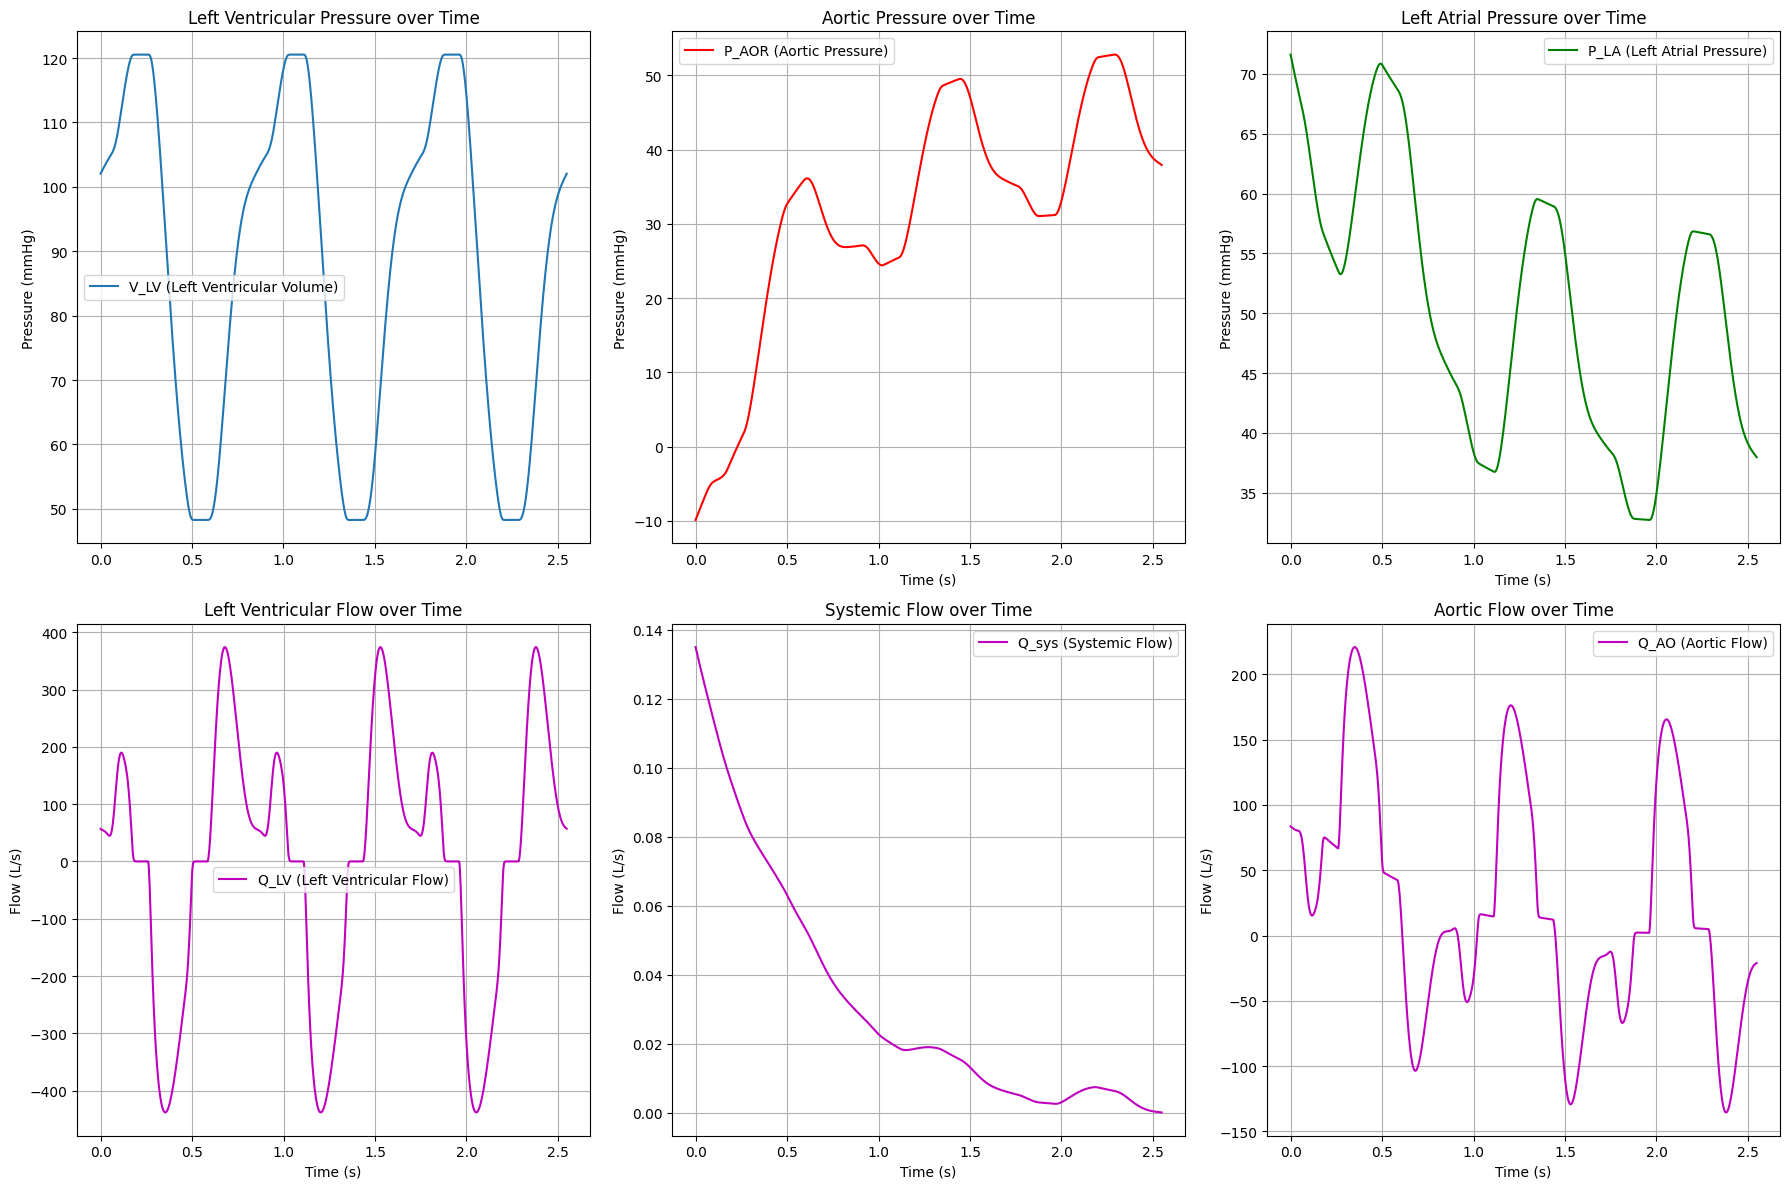

In [223]:

import matplotlib.pyplot as plt
# 绘制图形
plt.figure(figsize=(18, 12))

# 绘制左心室压力
plt.subplot(2, 3, 1)
plt.plot(time_series, V_LV, label='V_LV (Left Ventricular Volume)')
# plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Left Ventricular Pressure over Time')
plt.grid(True)
plt.legend()

# 绘制主动脉压力
plt.subplot(2, 3, 2)
plt.plot(time_points, P_AO_list, 'r', label='P_AOR (Aortic Pressure)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Aortic Pressure over Time')
plt.grid(True)
plt.legend()

# 绘制左心房压力
plt.subplot(2, 3, 3)
plt.plot(time_points, P_LA_list, 'g', label='P_LA (Left Atrial Pressure)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Left Atrial Pressure over Time')
plt.grid(True)
plt.legend()

# 绘制左心室流量
plt.subplot(2, 3, 4)
plt.plot(time_points, Q_LV_list, 'm', label='Q_LV (Left Ventricular Flow)')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Left Ventricular Flow over Time')
plt.grid(True)
plt.legend()

# 绘制左心室流量
plt.subplot(2, 3, 5)
plt.plot(time_points, Q_SYS_list, 'm', label='Q_sys (Systemic Flow)')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Systemic Flow over Time')
plt.grid(True)
plt.legend()

# 绘制左心室流量
plt.subplot(2, 3, 6)
plt.plot(time_points, Q_AO_list, 'm', label='Q_AO (Aortic Flow)')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Aortic Flow over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
# plt.show()
plt.savefig("LV_hyper_dynamic_results.png")

In [221]:
P_AO = np.loadtxt('p_ao.txt')
P_LA = np.loadtxt('p_la.txt')
P_LV = np.loadtxt('p_lv.txt')
V_LV = np.loadtxt('v_lv.txt')
V_LA = np.loadtxt('v_la.txt')

1276 1276 1276


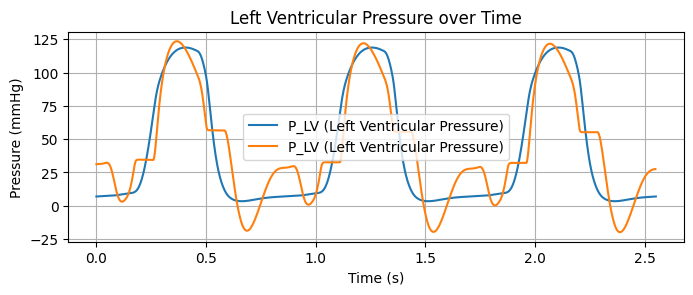

In [226]:
import matplotlib.pyplot as plt
# 绘制图形
plt.figure(figsize=(27, 6))

Q_LV = [(V_LV[i+1] - V_LV[i]) / dt for i in range(len(V_LV)-1)]
Q_LV.append(Q_LV[-1])  # 保持长度一致
print(len(Q_LV), len(time_series), len(P_LV))

# 绘制左心室压力
plt.subplot(2, 3, 1)
plt.plot(time_series, P_LV, label='P_LV (Left Ventricular Pressure)')
# plt.plot(time_series, Q_LV, label='Q_LV (Left Ventricular Flow)')
plt.plot(time_points, P_LV_list, label='P_LV (Left Ventricular Pressure)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Left Ventricular Pressure over Time')
plt.grid(True)
plt.legend()

plt.show()